In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-03-22 21:27
@Project  :   Hands-on Deep Learning with PyTorch-gradient_instability_and_dead_relu_problem
梯度不平稳性与Dead ReLU Problem
'''

# 导入所需的库
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.nn import functional as F

from layers.linears import L3ReLULR, SigmoidLR, L3SigmoidLR, L4TanhLR
from utils.data_gen_split import gen_reg_data, split_load_data
from utils.datasets import GenDataset
from utils.train_utils import fit, train_test_model

# 设置随机种子
torch.manual_seed(2023322)

模型病灶与模型调优：我们可能会很容易认为模型优化方法就是能让模型得出更好结果的方法，但实际上模型优化更像是对“患病”的模型进行诊断、然后对症下药，通过这些“治疗”方法，最终让模型运行恢复正常且健康的状态，并得出较好的模型预测结果。尽管优化方法就像一种种药品，各自都标注了适用的病症，但深度学习模型在某种程度上就像人体一样，是个非常复杂的系统，很多时候并不是“A药治A病”、并不是一个“只要...就...”的命题。模型优化和疾病治疗一样，很多时候都是多种手段作用于复杂系统、最终通过这个复杂系统自身的特性发挥作用，专业的模型调优是像医生那样为患者进行诊断，在了解病理的基础上，通过一些列更加专业的诊断手段判断病情，然后提出更加高效的综合性解决方案。初级算法工程师只需要知道模型会有什么样的问题（什么病）以及分别可以用什么方法解决（都有什么药），模型调优时主要靠套用和反复调试（多尝试各种办法），而更加专业的算法工程师则需要知道这些模型问题背后的成因，也就是到底是什么原因导致了模型出现这些问题（病理），同时也需要掌握更加丰富的诊断模型问题的一些方法（不仅仅是看模型评估指标结果），然后了解优化方法的基本原理以及发挥作用的方式，当然至关重要的一段是需要在长期实践中不断积累经验，才能最终获得专业性的长足的进步。
## 1.梯度消失与梯度爆炸推导
对于神经网络来说，在模型训练过程中最基础、同时也最常见的问题就是梯度消失和梯度爆炸。通过简化的公式推导来分析梯度消失和梯度爆炸的原因，假设有一个三层的神经网络，其中两个隐藏层的激活函数为$F(x)$，对应的导函数为$f(x)$，设X为输入训练的数据特征、y为标签，$\hat y$为模型向前传播输出结果，$w_1$为第一层参数、$w_2$为第二层参数、$w_3$为第三层参数，loss为损失函数，为了简化计算，假设所有的$x、w_1、w_2、w_3$都是标量，则：
输出层的输出为$\hat y = F(F(X * w_1) * w_2) * w_3$
loss是一个关于y和$\hat y$的函数，而y是常量、$\hat y$是一个关于w的函数，因此loss表示为$loss(\hat y)$

在进行梯度求解时候，假设$w_1$对应梯度为$grad_1$、$w_2$对应梯度为$grad_2$、$w_3$对应梯度为$grad_3$，根据链式法则，有计算过程如下：
$$
\begin{aligned}
grad_1 &=\frac{\partial loss}{\partial w_1} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial w_1} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial (F(F(X * w_1) * w_2) * w_3)}{\partial w_1} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial (F(F(X * w_1) * w_2) * w_3)}{\partial (F(F(X * w_1) * w_2)} \cdot \frac{\partial F(F(X * w_1) * w_2)}{\partial F(X * w_1)} \cdot \frac{\partial F(X * w_1)}{\partial w_1}\\
&= \frac{\partial loss}{\partial \hat y} \cdot w_3 \cdot f(F(X * w_1) * w_2) \cdot w_2 \cdot f(X * w_1) \cdot X \\
\end{aligned}
$$
可以看到，$grad_1$中包含了：（1）前两层隐含层激活函数的导数，$X * w_1$是第一层隐藏层接收到的数据，$F(X*w_1)*w_2$是第二层隐藏层接收到的数据；（2）后两层线性层的参数，即权重$w_2$和$w_3$；（3）当前梯度所在层的输入，即模型的初始输入$X$。
计算$w_2$的梯度如下：
$$
\begin{aligned}
grad_2 &=\frac{\partial loss}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial (F(F(X * w_1) * w_2) * w_3)}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial (F(F(X * w_1) * w_2) * w_3)}{\partial (F(F(X * w_1) * w_2)} \cdot \frac{\partial F(F(X * w_1) * w_2)}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y}
\cdot
w_3 \cdot \frac{\partial F(F(X * w_1) * w_2)}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y}
\cdot
w_3 \cdot f(F(X*w_1)*w_2) \cdot
\frac{\partial (F(X * w_1) * w_2)}{\partial w_2} \\
&= \frac{\partial loss}{\partial \hat y}
\cdot
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) \\
\end{aligned}
$$
此时，$grad_2$中包含了：（1）少了一层激活函数的导数，只有第2个隐含层激活函数的导数；（2）第3层线性层的参数$w_3$；（3）第2个线性层接收到的输入。
$w_3$的梯度计算如下：
$$
\begin{aligned}
grad_3 &=\frac{\partial loss}{\partial w_3} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial \hat y}{\partial w_3} \\
&= \frac{\partial loss}{\partial \hat y} \cdot \frac{\partial (F(F(X * w_1) * w_2) * w_3)}{\partial w_3} \\
&= \frac{\partial loss}{\partial \hat y} \cdot F(F(X * w_1) * w_2) \\
\end{aligned}
$$
此时$grad_3$在计算过程中已经不涉及激活函数的导数计算，只有第3层线性层的输入。
如果当神经网络层数继续增加、激活函数的数量继续增加，第1层参数在计算梯度的过程中需要相乘的激活函数导函数个数也会随之增加，而后面各层参数的梯度计算中涉及到的激活函数导函数个数逐级递减，累乘容易造成指数级变化：
当激活函数值$F(F(X*w_1))$、激活函数导函数值$f(X*w_1)$或者参与相乘的参数取值（$w_3$）较大(>1)时，会出现$grad_1$远大于$grad_2$远大于$grad_3$的情况，也就是神经网络前几层参数梯度非常大、而后几层参数梯度相对较小，此时就称为**梯度爆炸**，并且受到累乘效应的影响，前几层梯度也会大于甚至远大于1，此时就会造成模型迭代过程不稳定的情况发生；
而反之，如果这些变量均小于1，甚至远小于1，则会出现前几层参数梯度非常小、而后几层参数梯度非常大的情况，此时就被称为**梯度消失**，此时由于模型各层参数学习率伴随层数增加逐渐增加，并且由于构成梯度的基本参数均小于1，因此最后几层梯度也会小于1甚至远小于1，此时前几层参数梯度取值将非常小，甚至趋于0，因而会使得前几层的参数无法在迭代中得到有效更新。

不同层参数的梯度在计算过程中都有很大的差异，并且这种差异是一种累乘效应，可以简单理解为是一种伴随着层数增加指数级变化的差异，而这种累乘效应会导致线性层参数的一部分梯度过大而另一部分过小，从而影响模型平稳训练。每一层参数的梯度主要和两个因素相关：一是线性层输入数据，如$X$或$F(X*W)$；二是激活函数导函数的计算结果$f(X*W)$。线性层的输入是相对固定的，因此一个优化的出发点就是从激活函数的角度考虑。
## 2.Sigmoid激活函数的梯度更新问题
### 模型参数及梯度提取

In [2]:
# 生成数据
features, labels = gen_reg_data(w=(2, -1), bias=False, deg=2)
labels.unsqueeze_(-1)
# 数据切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x224ce773cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x224ce773ac0>)

In [3]:
# 实例化有3个Sigmoid激活函数层的模型
sigmoid_lr_l3 = L3SigmoidLR()
sigmoid_lr_l3

L3SigmoidLR(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (linear2): Linear(in_features=4, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=4, bias=True)
  (linear4): Linear(in_features=4, out_features=1, bias=True)
)

In [4]:
# 使用parameters()方法获取模型的所有参数
params = list(sigmoid_lr_l3.parameters())  # 包括各层的权重和截距，PyTorch的参数与普通参数相比，进行了转置
params

[Parameter containing:
 tensor([[-0.2122, -0.4238],
         [ 0.4494, -0.1667],
         [ 0.2247, -0.4400],
         [-0.0693,  0.2268]], requires_grad=True),
 Parameter containing:
 tensor([-0.0545,  0.3394, -0.0578, -0.4775], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0016,  0.0879, -0.0550,  0.3416],
         [-0.4355, -0.3137, -0.2607, -0.0007],
         [ 0.1069,  0.4773,  0.3004,  0.2910],
         [ 0.0236, -0.0358, -0.2539, -0.1934]], requires_grad=True),
 Parameter containing:
 tensor([-0.0999, -0.1335, -0.3740,  0.4130], requires_grad=True),
 Parameter containing:
 tensor([[-0.2815, -0.3925, -0.2392,  0.4169],
         [-0.1931,  0.0076, -0.0846, -0.0186],
         [ 0.1413, -0.3564, -0.3462,  0.4714],
         [ 0.3198, -0.1980,  0.1015, -0.4673]], requires_grad=True),
 Parameter containing:
 tensor([-0.3819, -0.0815,  0.3191, -0.1764], requires_grad=True),
 Parameter containing:
 tensor([[-0.2116,  0.4556,  0.0961,  0.2396]], requires_grad=True),
 Parameter 

In [5]:
# 数据输入模型
feature = features[:1, :]
sigmoid_lr_l3(feature)  # features数据默认按行排列

tensor([[0.5634]], grad_fn=<AddmmBackward0>)

In [6]:
# modules()方法查看模型的所有模块
modules = list(sigmoid_lr_l3.modules())  # 第一个模块是其本身，其他模块是组成该模型的子模块，分别为4个线性层
modules

[L3SigmoidLR(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=4, bias=True)
   (linear4): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=1, bias=True)]

In [7]:
# 获取第1个线性层的输出
modules[1](feature)

tensor([[ 0.6144,  0.6151,  0.6472, -0.8397]], grad_fn=<AddmmBackward0>)

In [8]:
# 手动实现数据输入和模型计算
feature @ params[0].t() + params[1].t()  # w * x + b，结果与前面一致

tensor([[ 0.6144,  0.6151,  0.6472, -0.8397]], grad_fn=<AddBackward0>)

In [9]:
# 通过modules查看第1个线性层的参数，线性层也可以作为一个独立的模型
list(modules[1].parameters())

[Parameter containing:
 tensor([[-0.2122, -0.4238],
         [ 0.4494, -0.1667],
         [ 0.2247, -0.4400],
         [-0.0693,  0.2268]], requires_grad=True),
 Parameter containing:
 tensor([-0.0545,  0.3394, -0.0578, -0.4775], requires_grad=True)]

In [10]:
# 调用线性层的属性来获取参数
modules[1].weight, modules[1].bias  # 与前面一致

(Parameter containing:
 tensor([[-0.2122, -0.4238],
         [ 0.4494, -0.1667],
         [ 0.2247, -0.4400],
         [-0.0693,  0.2268]], requires_grad=True),
 Parameter containing:
 tensor([-0.0545,  0.3394, -0.0578, -0.4775], requires_grad=True))

In [11]:
# 建模过程中，可能需要根据情况提取权重或截距，例如进行权重初始化
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.data)

for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.bias.data)

tensor([[-0.2122, -0.4238],
        [ 0.4494, -0.1667],
        [ 0.2247, -0.4400],
        [-0.0693,  0.2268]])
tensor([[ 0.0016,  0.0879, -0.0550,  0.3416],
        [-0.4355, -0.3137, -0.2607, -0.0007],
        [ 0.1069,  0.4773,  0.3004,  0.2910],
        [ 0.0236, -0.0358, -0.2539, -0.1934]])
tensor([[-0.2815, -0.3925, -0.2392,  0.4169],
        [-0.1931,  0.0076, -0.0846, -0.0186],
        [ 0.1413, -0.3564, -0.3462,  0.4714],
        [ 0.3198, -0.1980,  0.1015, -0.4673]])
tensor([[-0.2116,  0.4556,  0.0961,  0.2396]])
tensor([-0.0545,  0.3394, -0.0578, -0.4775])
tensor([-0.0999, -0.1335, -0.3740,  0.4130])
tensor([-0.3819, -0.0815,  0.3191, -0.1764])
tensor([0.2798])


In [12]:
# 获取各线性层的梯度：.grad
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.grad)

for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.bias.grad)

None
None
None
None
None
None
None
None


### Sigmoid激活函数的梯度消失问题
对于Sigmoid激活函数来说，简单的叠加极容易出现梯度消失的问题。

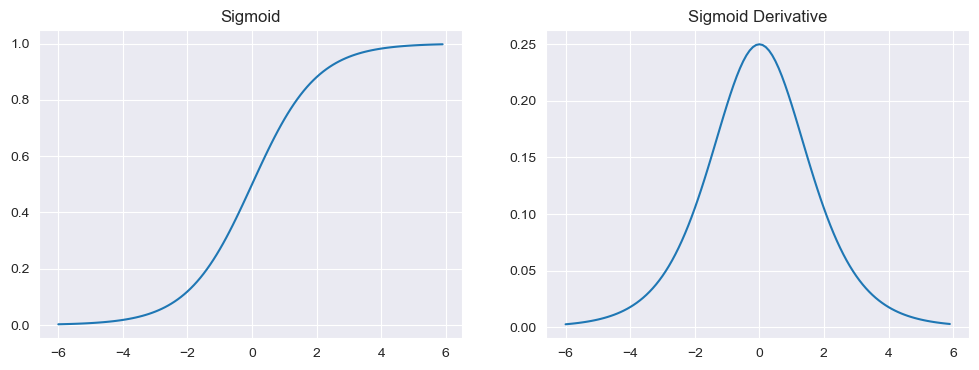

In [13]:
# 绘制Sigmoid函数及其导函数的图像
X = torch.arange(-6, 6, 0.1, requires_grad=True)
s = torch.sigmoid(X)

# 反向传播，求解梯度
s.sum().backward()

# 可视化Sigmoid函数与导函数
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X.detach(), s.detach())
plt.title('Sigmoid')
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title('Sigmoid Derivative')
plt.show()

可以看到，Sigmoid导函数在0点处取到最大值为0.25，当x较大或者较小时，导函数取值趋于0。在上述结构的三层神经网络中，第1层参数梯度$grad_1$由于计算过程出现两次导函数连乘，哪怕两次都导函数都取到最大值0.25（虽然可能性较小），$grad_1$也会在0.0625的基础上进行其余部分相乘，最终结果也极有可能是个非常小的值，因此对于Sigmoid激活函数叠加的情况来说，是极容易出现梯度消失情况的。

**Sigmoid函数饱和区间**：Sigmoid函数左右两端的区间称为函数的饱和区间，也就是自变量绝对值较大的区间，当自变量落入饱和区间时，因变量会趋于0或者1，而无论自变量是极小（负数绝对值极大）还是极大，导函数取值都趋于0，从而更容易导致模型梯度消失。

先对模型训练5个epoch，并观察参数变化情况。

In [14]:
# 设置超参数
num_epochs = 5
lr = 0.03

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(sigmoid_lr_l3.parameters(), lr=lr)

# 迭代训练
fit(sigmoid_lr_l3, criterion, optimizer, train_loader, num_epochs=num_epochs)

In [15]:
# 再查看权重参数
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.data)  # 与训练前相比，第1层参数变化非常小，后面层参数变化逐渐增大，最后1层参数变化较大

tensor([[-0.2109, -0.4239],
        [ 0.4494, -0.1671],
        [ 0.2265, -0.4397],
        [-0.0678,  0.2267]])
tensor([[ 1.5848e-04,  8.8522e-02, -5.4581e-02,  3.4109e-01],
        [-4.3235e-01, -3.1202e-01, -2.5963e-01,  1.9170e-03],
        [ 1.0908e-01,  4.7845e-01,  3.0128e-01,  2.9254e-01],
        [ 2.2140e-02, -4.1169e-02, -2.5811e-01, -1.9574e-01]])
tensor([[-0.2994, -0.4045, -0.2592,  0.3979],
        [-0.1910,  0.0087, -0.0785, -0.0170],
        [ 0.1267, -0.3664, -0.3602,  0.4555],
        [ 0.3147, -0.2016,  0.0984, -0.4731]])
tensor([[-0.1001,  0.5720,  0.2631,  0.3612]])


In [16]:
# 查看梯度
for module in sigmoid_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.grad)  # 前几层梯度较小，后面几层梯度逐渐增大，最后一层梯度最大

tensor([[ 1.7925e-04,  7.0708e-04],
        [ 1.4027e-06,  1.7272e-04],
        [ 9.5124e-06,  3.2812e-04],
        [-1.1961e-05,  2.8746e-04]])
tensor([[-3.2307e-04,  5.8022e-05, -2.5018e-04,  3.9826e-04],
        [ 5.2453e-04, -1.7607e-04,  4.1233e-04, -8.2268e-04],
        [ 3.9825e-04, -9.4301e-05,  3.0366e-04, -5.1933e-04],
        [ 4.7954e-04, -8.3577e-05,  3.7134e-04, -5.8630e-04]])
tensor([[-0.0012, -0.0012, -0.0009, -0.0012],
        [ 0.0079,  0.0079,  0.0060,  0.0080],
        [ 0.0036,  0.0036,  0.0027,  0.0037],
        [ 0.0049,  0.0049,  0.0037,  0.0050]])
tensor([[0.0321, 0.0431, 0.0549, 0.0401]])


In [17]:
# 更直观的观测方式：绘制小提琴图
layer_grads = []

# 记录梯度
for idx, module in enumerate(sigmoid_lr_l3.modules()):
    if isinstance(module, nn.Linear):
        layer_grad = module.weight.grad.reshape(-1, 1).numpy()  # 每一层的梯度
        index = np.full_like(layer_grad, idx)  # 对层进行标号
        layer = np.concatenate((layer_grad, index), -1)
        layer_grads.append(layer)

# 拼接各层
layer_grads = np.concatenate(layer_grads, 0)
layer_grads

array([[ 1.7925372e-04,  1.0000000e+00],
       [ 7.0708321e-04,  1.0000000e+00],
       [ 1.4027173e-06,  1.0000000e+00],
       [ 1.7271723e-04,  1.0000000e+00],
       [ 9.5124124e-06,  1.0000000e+00],
       [ 3.2812404e-04,  1.0000000e+00],
       [-1.1960830e-05,  1.0000000e+00],
       [ 2.8745737e-04,  1.0000000e+00],
       [-3.2306986e-04,  2.0000000e+00],
       [ 5.8022153e-05,  2.0000000e+00],
       [-2.5018229e-04,  2.0000000e+00],
       [ 3.9826368e-04,  2.0000000e+00],
       [ 5.2453170e-04,  2.0000000e+00],
       [-1.7606642e-04,  2.0000000e+00],
       [ 4.1233026e-04,  2.0000000e+00],
       [-8.2267693e-04,  2.0000000e+00],
       [ 3.9824634e-04,  2.0000000e+00],
       [-9.4300893e-05,  2.0000000e+00],
       [ 3.0366407e-04,  2.0000000e+00],
       [-5.1932607e-04,  2.0000000e+00],
       [ 4.7953846e-04,  2.0000000e+00],
       [-8.3576946e-05,  2.0000000e+00],
       [ 3.7134293e-04,  2.0000000e+00],
       [-5.8629800e-04,  2.0000000e+00],
       [-1.23467

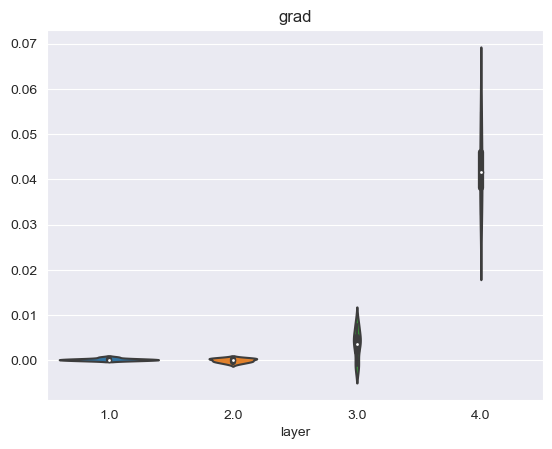

In [18]:
# 绘制各层参数梯度的小提琴图
ax = sns.violinplot(y=layer_grads[:, 0], x=layer_grads[:, 1])
ax.set(xlabel='layer', title='grad')
plt.show()

可以看到，从右到左表示层数由高到低，同时各层的梯度分布区间逐渐变窄，同时梯度的绝对大小也逐渐减小、向0靠近，第1层的梯度几乎都分布在0附近，存在着严重的梯度消失问题。
其中，小提琴图的说明如下：

![seaborn_violin_plot_illustration](../assets/seaborn_violin_plot_illustration.png)

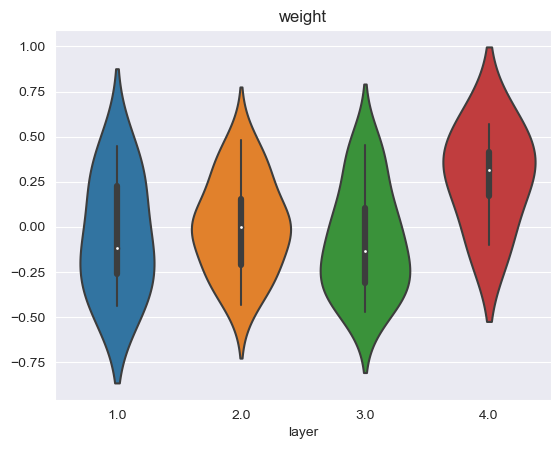

In [19]:
# 绘制各层参数的小提琴图
layer_weights = []

# 记录梯度
for idx, module in enumerate(sigmoid_lr_l3.modules()):
    if isinstance(module, nn.Linear):
        layer_weight = module.weight.detach().reshape(-1, 1).numpy()  # 每一层的权重
        index = np.full_like(layer_weight, idx)  # 对层进行标号
        layer = np.concatenate((layer_weight, index), -1)
        layer_weights.append(layer)

# 拼接各层
layer_weights = np.concatenate(layer_weights, 0)

# 绘制图像
ax = sns.violinplot(y=layer_weights[:, 0], x=layer_weights[:, 1])
ax.set(xlabel='layer', title='weight')
plt.show()  # 各层权重分布相近，同时因为前面的层存在梯度消失，所以更新较慢、区间更大

In [20]:
# 将绘制小提琴图的过程封装为函数
def violin_plot_layers(model, is_grad=True):
    '''
    绘制模型参数或梯度的小提琴图
    :param model: 模型
    :param is_grad: 是否画梯度
    :return: None
    '''
    layer_params = []

    # 记录梯度
    for idx, module in enumerate(model.modules()):
        if isinstance(module, nn.Linear):
            if is_grad:
                layer_param = module.weight.grad.reshape(-1, 1).numpy()  # 每一层的梯度
            else:
                layer_param = module.weight.detach().reshape(-1, 1).numpy()  # 每一层的权重
            index = np.full_like(layer_param, idx)  # 对层进行标号
            layer = np.concatenate((layer_param, index), -1)
            layer_params.append(layer)

    # 拼接各层
    layer_params = np.concatenate(layer_params, 0)

    # 绘制图像
    ax = sns.violinplot(y=layer_params[:, 0], x=layer_params[:, 1])
    ax.set(xlabel='layer', title='grad' if is_grad else 'weight')
    plt.show()

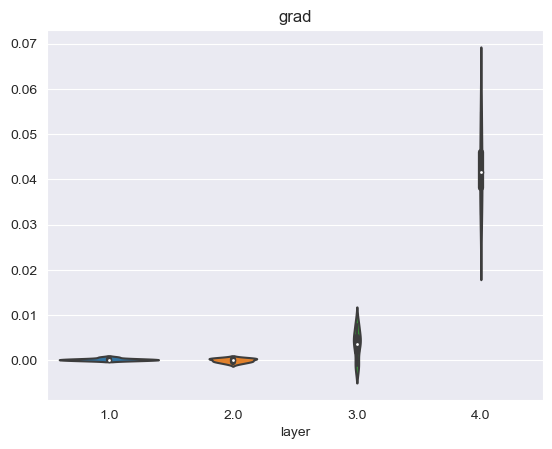

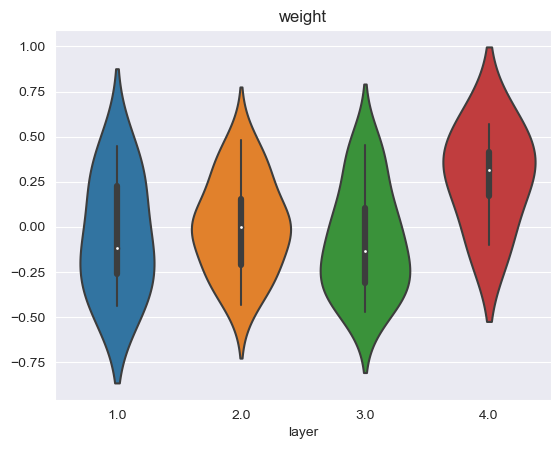

In [21]:
# 测试函数
violin_plot_layers(sigmoid_lr_l3)
violin_plot_layers(sigmoid_lr_l3, is_grad=False)

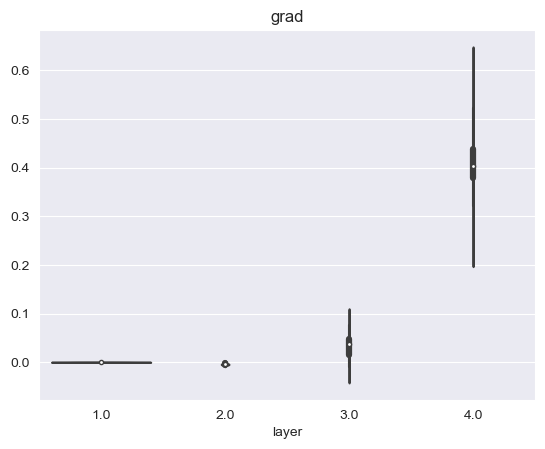

In [22]:
# 增加训练轮数、观察模型的梯度消失问题
num_epochs = 15
fit(sigmoid_lr_l3, criterion, optimizer, train_loader, num_epochs=num_epochs)

# 绘梯度图
violin_plot_layers(sigmoid_lr_l3)

可以看到，Sigmoid激活函数的梯度消失问题会随着迭代轮数和隐含层的层数增加而更加明显。从梯度消失的角度来解释前面遇到的Sigmoid简单叠加带来的模型不收敛或收敛慢：

![sigmoid_stacked_compare](../assets/sigmoid_stacked_compare.png)

一方面，叠加的Sigmoid激活函数层越多，收敛得越慢，所以4层Sigmoid叠加收敛得最慢，甚至一直没有收敛；另一方面，增加了Sigmoid激活函数层也没有带来更好的模型兴效果，2、3层Sigmoid模型最后收敛的水平与只有1层Sigmoid模型的水平相当，但是还更慢。由于3层Sigmoid（即前面进行实例化而训练的模型）存在着严重的梯度消失问题，特别是前2层线性层，所以前两层的参数无法进行有效的更新，实际上进行更新的参数只有后两个线性层，即等价于只有2个线性层，也就是只有1个Sigmoid层的模型，所以sigmoid_lr_l3模型的效果与sigmoid_lr_l1和sigmoid_lr_l2的效果是接近的；同时，由于Sigmoid层的叠加容易导致梯度消失的问题，各层线性层特别是靠近前面的各层的梯度的值都较小，因此在迭代的过程中权重的更新区间也很小，即权重很难出现大幅度的波动，一般处于一个比较稳定的变化趋势，参数基本不会发生突变，收敛也呈现出相对平稳的特点。因此，对于复杂模型来说，如果部分层失去学习能力（参数迭代的可能性），其实模型判别效力就和简单模型无异，还不如使用简单的模型，从中也能看出对复杂模型进行有效训练的重要性。
## 3.Tanh激活函数的梯度更新问题

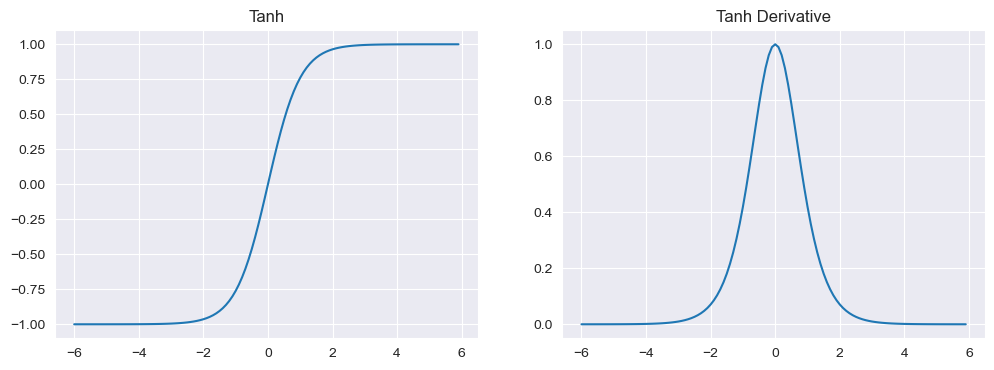

In [23]:
# 绘制Tanh函数及其导函数的图像
X = torch.arange(-6, 6, 0.1, requires_grad=True)
t = torch.tanh(X)

# 反向传播，求解梯度
t.sum().backward()

# 可视化Tanh函数与导函数
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X.detach(), t.detach())
plt.title('Tanh')
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title('Tanh Derivative')
plt.show()

可以看到，Tanh导函数的取值分布在0-1之间，看似导函数取值累乘之后也是趋于0的，但实际上Tanh激活函数的叠加既可能造成梯度消失，也可能造成梯度爆炸，因为在实际建模过程中影响前几层梯度的其他变量大多数情况都大于1，因此对于一个导函数极大值可以取到1的激活函数来说，还是有可能出现梯度爆炸的。同时，梯度爆炸和梯度消失中所谓的前几层参数梯度过大或过小都是相对的，并没有明确定义梯度大过多少就是梯度爆炸、梯度小过多少就是梯度消失。另外，梯度爆炸和梯度消失的直接表现可归结为前后层参数梯度不一致，而二者的根本后果都是影响迭代收敛过程。

作为Sigmoid激活函数的“升级版”，Tanh激活函数本身就能够一定程度规避梯度消失问题，同时还能输出Zero-Centered Data（零均值数据），而确保输入层接收到Zero-Centered Data就是解决梯度消失和梯度爆炸问题的关键：当前层Tanh函数的输出结果有正有负，这样的激活值传到下一层时，与下一层的参数相乘，更有可能输出零均值数据，在输入到下一层的Tanh激活函数时，其导函数值更有可能是1，从而减少梯度消失和梯度爆炸发生的可能。而Sigmoid函数的输出结果都是正值、不能输出零均值数据，因此传入下一层的数据也有很大可能不是零均值数据，因此下一层Sigmoid激活函数的导函数输出结果可能就会很小，进而导致前几层的梯度计算结果很小，带来梯度消失。

下面通过小提琴图可视化带Tanh激活函数的模型的参数和梯度变化情况。

In [24]:
# 实例化模型
tanh_lr_l4 = L4TanhLR()

# 查看各层参数
for module in tanh_lr_l4.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.data)

tensor([[ 0.1990,  0.5430],
        [ 0.6533,  0.5607],
        [-0.2148, -0.0780],
        [ 0.0237, -0.3212]])
tensor([[ 0.3247,  0.4953,  0.3891,  0.3816],
        [ 0.2959, -0.1080,  0.2529, -0.0074],
        [ 0.3875, -0.2857, -0.0478,  0.0042],
        [-0.4370,  0.0334, -0.4749,  0.4489]])
tensor([[ 0.4321,  0.1555,  0.3205,  0.2886],
        [ 0.1558,  0.1093, -0.4399, -0.0887],
        [ 0.2045, -0.4381,  0.2516,  0.4048],
        [-0.0238,  0.2468, -0.3585, -0.3939]])
tensor([[ 0.0886,  0.1472, -0.2006,  0.0472],
        [ 0.2533, -0.0838, -0.0896,  0.1261],
        [-0.1781, -0.4118,  0.3507, -0.2949],
        [ 0.3371,  0.2128, -0.3080, -0.4663]])
tensor([[ 0.2840, -0.0972,  0.2889, -0.0835]])


In [25]:
# 迭代训练
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(tanh_lr_l4.parameters(), lr=lr)

# 迭代训练
num_epochs = 5
fit(tanh_lr_l4, criterion, optimizer, train_loader, num_epochs=num_epochs)

In [26]:
# 再查看各层参数
for module in tanh_lr_l4.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.data)  # 肉眼观察，各层参数变化较大

tensor([[-0.3637,  0.9228],
        [ 0.9407,  0.7079],
        [-0.0946,  0.3039],
        [-0.1688, -0.3492]])
tensor([[ 0.5780,  0.6400,  0.4643,  0.3273],
        [ 0.5491, -0.2212,  0.2268,  0.1250],
        [ 0.3018, -0.4156, -0.0414, -0.0083],
        [-0.8190, -0.5615, -0.5339,  0.5148]])
tensor([[ 0.6430,  0.2302,  0.3334, -0.0799],
        [ 0.3446,  0.1459, -0.3802, -0.3689],
        [-0.1446, -0.4674,  0.2377,  0.8927],
        [ 0.2439,  0.2795, -0.3409, -0.7432]])
tensor([[ 0.0394,  0.1653, -0.1729,  0.0216],
        [ 0.3134, -0.0296, -0.3287,  0.3327],
        [-0.4014, -0.5820,  0.8232, -0.7364],
        [ 0.3429,  0.1915, -0.3669, -0.4246]])
tensor([[ 0.0119, -0.3935,  1.0789, -0.0904]])


In [27]:
# 查看各层参数梯度
for module in tanh_lr_l4.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.grad)  # 肉眼观察，各层之间参数梯度整体分布相对于Sigmoid更均匀，但是各层梯度依然存在着严重不均，并且前几层的分布不均的现象更明显

tensor([[-0.5852, -1.5638],
        [ 0.0688, -0.5772],
        [-0.3329, -1.0700],
        [-0.0924,  0.2816]])
tensor([[-0.0240, -0.5174,  0.1019,  0.2604],
        [ 0.0245, -0.4357,  0.1309,  0.2122],
        [ 0.0276,  0.1983, -0.0649, -0.0990],
        [ 0.1102,  0.7405, -0.2219, -0.3712]])
tensor([[-0.1099,  0.1112,  0.2390,  0.1454],
        [-0.0120, -0.0325,  0.1524,  0.0106],
        [ 0.0547,  0.0315, -0.2704, -0.0620],
        [-0.0158, -0.0653,  0.2051,  0.0113]])
tensor([[-0.0044,  0.0089, -0.0055,  0.0078],
        [ 0.0567, -0.1929,  0.1340, -0.1755],
        [-0.0643,  0.1447, -0.0003,  0.0408],
        [ 0.0260, -0.0598,  0.0418, -0.0560]])
tensor([[ 0.1836,  0.2139, -0.4709, -0.0806]])


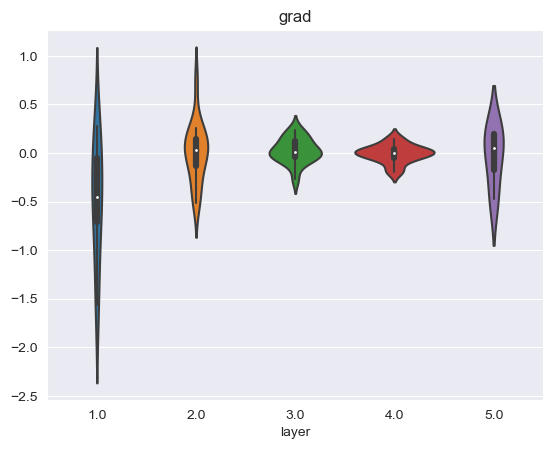

In [28]:
# 绘制模型各层梯度的小提琴图
violin_plot_layers(tanh_lr_l4)

可以看到，梯度存在少量极端值，模型存在一定程度的梯度爆炸的情况，同时，对于Tanh激活函数来说，由于激活函数本身的良好特性，即能够输出Zero-Centered Data，一般不会出现明显的梯度消失。但梯度爆炸会极大影响模型训练过程的稳定性，并且这种现象并不会因为模型迭代次数增加而消失。典型的梯度爆炸现象的表现是靠近前面的层的梯度非常大，越靠近后面的层梯度逐渐减小。

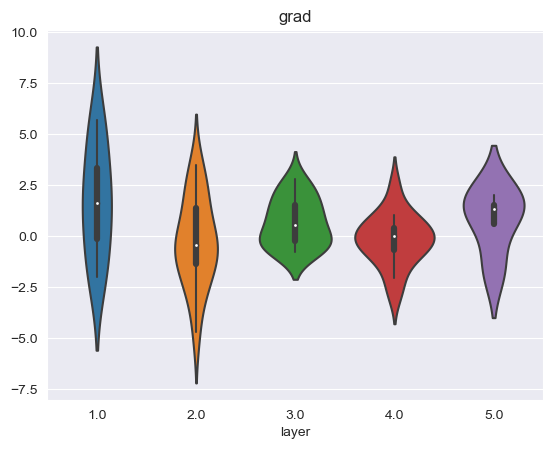

In [29]:
# 继续训练
num_epochs = 15
fit(tanh_lr_l4, criterion, optimizer, train_loader, num_epochs=num_epochs)

# 再次可视化
violin_plot_layers(tanh_lr_l4)

可以看到，随着迭代次数增加，各层的梯度之间的分布仍然不均匀，同时有的层分布区间较大，存在一些极端值，极端值的数量也有所增多、分布更加扁平，这些梯度的极端值会导致梯度爆炸的情况有增无减，因此使用多层Tanh激活函数进行叠加会带来很严重的不平稳，如下所示：
![tanh_stacked_compare](../assets/tanh_stacked_compare.png)

这样的训练过程得到的模型显然是不可信的。从根本上来说，Tanh激活函数的迭代不平稳就是因为部分层的部分梯度存在极端值，这种极端值一方面会导致参数更新幅度非常大，从而导致模型表现不稳定，另一方面也导致部分层无法有效学习、影响模型的最终效果。

## 4.零均值数据与Glorot条件
通过对Sigmoid和Tanh激活函数叠加后的模型梯度变化情况分析可以发现，梯度不平稳是影响模型建模效果的核心因素。整体来看，针对梯度不平稳的解决方案（优化方法）总共分为五类，分别是参数初始化方法、输入数据的归一化方法、衍生激活函数的使用、学习率调度方法以及梯度下降优化方法。虽然不同优化算法有不同的出发点和不同的论证方式，但基本都可以从Glorot条件出发进行思考。
为了确保多层神经网络的有效性，各层梯度的差距不应太大，此时就需要使得各层的激活函数的导数值接近1或一个大小合适的常值，此时一个最为基本的想法就是让所有的输入数据（即X）以及所有层的参数都设置为Zero-Centered Data，也就是零点对称数据，不难发现，如果X和$w_i$都是零点对称的，那么每一个线性层中的导函数的取值都能维持在0-1之间，进而使得每一层的梯度基本都能维持在比较平稳的状态。同时，除了能够避免梯度不平稳问题，创建Zero-Centered的参数和数据集还能更好地在正向传播中将信息传播到各层，以及确保各层学习的平稳性。
为了将带入模型训练的数据转化为Zero-Centered Data，一般会使用一系列标准化方法对其进行转化。对于输入的数据来说，保证其Zero-Centered的特性是相对容易的，但模型参数是随着模型迭代不断变化的，我们无法把控模型每一轮迭代后的情况，因此只能从**模型参数的初始化**入手，尽量保证其Zero-Centered属性。

In [30]:
# 尝试使得参数值都为0，也满足零均值，验证是否可行
sigmoid_lr = SigmoidLR(bias=False)
# 查看参数
list(sigmoid_lr.parameters())

[Parameter containing:
 tensor([[-0.5246, -0.6044],
         [-0.2186,  0.5472],
         [ 0.1267, -0.4202],
         [-0.7020,  0.3457]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0161,  0.1745, -0.1919, -0.4515]], requires_grad=True)]

In [31]:
# 将各层参数改为0
sigmoid_lr.linear1.weight.data.fill_(0)
sigmoid_lr.linear2.weight.data.fill_(0)

# 再次查看参数
list(sigmoid_lr.parameters())  # 全为0

[Parameter containing:
 tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0., 0.]], requires_grad=True)]

In [32]:
# 进行迭代训练
num_epochs = 5
optimizer = optim.SGD(sigmoid_lr.parameters(), lr=lr)
fit(sigmoid_lr, criterion, optimizer, train_loader, num_epochs=num_epochs)

# 再次查看参数
list(sigmoid_lr.parameters())  # 参数的每一列相同

[Parameter containing:
 tensor([[0.3093, 0.0406],
         [0.3093, 0.0406],
         [0.3093, 0.0406],
         [0.3093, 0.0406]], requires_grad=True),
 Parameter containing:
 tensor([[0.6131, 0.6131, 0.6131, 0.6131]], requires_grad=True)]

可以看到，当设置权重的初始值为0时，最后每一轮迭代之后参数的每一列都是相同的，相同的参数体现导致神经元没有区分性，还可能带来权重无法更新的问题，具体原因可参考[https://zhuanlan.zhihu.com/p/378418174](https://zhuanlan.zhihu.com/p/378418174)和[https://blog.csdn.net/qq_37568167/article/details/105912695](https://blog.csdn.net/qq_37568167/article/details/105912695)。

因为不能将参数的初始值全部设为0，因此只能考虑生成均值是0的随机数，也就是0均值的均匀分布或者是0均值的高斯分布，此时要考虑的另一个问题是确定该随机数的方差。初始化参数的方差如何确定这一问题在一篇严谨论述如何保证模型有效性的论文[Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)中从另一个角度出发提供了解决思路，根据作者Xavier Glorot在论文中的观点，为保证模型本身的有效性和稳定性，我们希望：正向传播时，每个线性层输入数据的方差等于输出数据的方差；反向传播时，数据流经某层之前和流经某层之后该层的梯度也具有相同的方差。这种正向传播时数据方差保持一致、反向传播时参数梯度方差保持一致的条件，被称为**Glorot条件**，满足该条件的模型能够进行有效平稳的训练。虽然二者很难同时满足（除非相邻两层神经元个数相同），但Glorot和Bengio表示，如果适当修改计算过程，是可以找到一种折中方案去设计初始参数取值，从而同时保证二者条件尽可能得到满足，为了满足该条件而创建的模型初始化参数值设计方法，被称为**Xavier方法**，Xavier方法解决的最核心问题就是为了创建Zero-Centered的初始化参数时参数的方差，这种方法经过一段时间的实践验证被证明是很好的一种初始化模型参数的方法，尤其是对于使用Tanh激活函数的神经网络来说，效果更为显著。

由于Glorot条件和Xavier方法是在2010年提出的，彼时ReLU激活函数还未兴起，因此Xavier方法主要是围绕Tanh激活函数可能存在的梯度爆炸或梯度消失进行的优化，Sigmoid激活函数效果次之。不过尽管如此，Glorot条件却是一个通用条件，后续围绕ReLU激活函数、用于解决神经元活性失效的优化方法（如HE初始化方法），也是遵照Glorot条件进行的方法设计。

模型的初始参数取值不同，会得到不同的建模结果，因为模型初始化时得到的不同参数，本质上等价于在损失函数上找到了不同的初始点，而同一损失函数，初始点选取的不同会影响最终迭代结果才对，一个重要原因就是因为很有可能跳入局部最优值陷阱。下面验证模型初始化参数取值对模型效果的影响，因为在不采用特定的初始化方法时，模型的初始化默认都是采用随机方式进行初始化的，因此两次独立初始化的模型，其参数因为随机特性都会是不同的。

In [33]:
# 实例化模型
relu_lr_l3 = L3ReLULR()

# 查看参数
list(relu_lr_l3.parameters())

[Parameter containing:
 tensor([[-0.4986, -0.3892],
         [-0.5096,  0.6951],
         [-0.4616,  0.0451],
         [-0.1588, -0.5232]], requires_grad=True),
 Parameter containing:
 tensor([0.6853, 0.2210, 0.5807, 0.3868], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3795, -0.4324, -0.1336,  0.2493],
         [-0.3765, -0.2401, -0.0007,  0.4831],
         [ 0.4651,  0.0938, -0.0265,  0.4899],
         [-0.0515,  0.1337, -0.1973,  0.2756]], requires_grad=True),
 Parameter containing:
 tensor([-0.3180, -0.3501,  0.0671, -0.3027], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3735,  0.3143,  0.4520,  0.1400],
         [-0.0697, -0.3948, -0.4804,  0.4651],
         [ 0.0223,  0.1929, -0.2922,  0.3325],
         [-0.0987,  0.0268, -0.2855,  0.0819]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2983, -0.4906,  0.2901,  0.2539], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4903, -0.1676,  0.2276, -0.3814]], requires_grad=True),
 Parameter cont

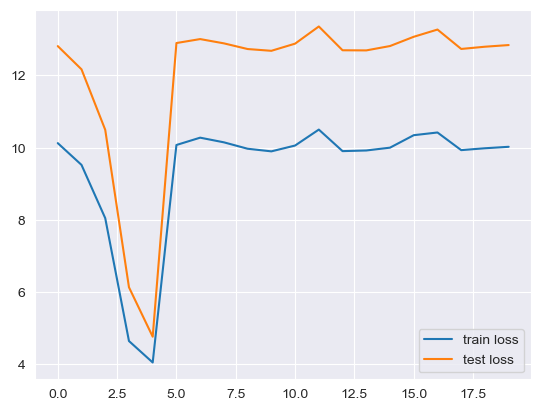

In [34]:
# 超参数
num_epochs = 20

# 迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs)

# 可视化训练结果
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()

In [35]:
# 再次实例化模型
relu_lr_l3 = L3ReLULR()

# 再次查看参数
list(relu_lr_l3.parameters())  # 参数与上一次不同

[Parameter containing:
 tensor([[-0.2561, -0.3623],
         [-0.5993, -0.4858],
         [-0.0277,  0.1807],
         [ 0.2515,  0.4810]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1940,  0.4521,  0.4033, -0.0223], requires_grad=True),
 Parameter containing:
 tensor([[-0.2433,  0.3153, -0.2872,  0.2755],
         [-0.1832,  0.4927, -0.0351, -0.0268],
         [ 0.0529, -0.2107, -0.2546, -0.1811],
         [ 0.3375,  0.1512, -0.4186,  0.0077]], requires_grad=True),
 Parameter containing:
 tensor([-0.0598,  0.1071, -0.4338,  0.2211], requires_grad=True),
 Parameter containing:
 tensor([[-0.2995,  0.1712, -0.2591,  0.0384],
         [ 0.2920, -0.0220, -0.3115,  0.4883],
         [ 0.4183,  0.3171,  0.1941,  0.1984],
         [-0.2731,  0.0898, -0.2316,  0.2092]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0362,  0.4316, -0.1870, -0.3596], requires_grad=True),
 Parameter containing:
 tensor([[0.4365, 0.3507, 0.0162, 0.4866]], requires_grad=True),
 Parameter cont

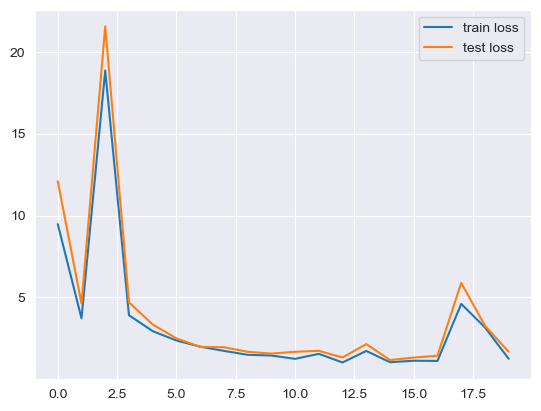

In [36]:
# 再次迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs)

# 再次可视化训练结果
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 曲线与上次不同

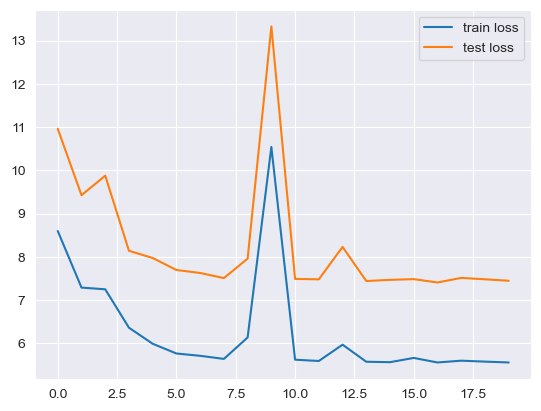

In [37]:
# 再次实例化模型
relu_lr_l3 = L3ReLULR()

# 再次迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs)

# 再次可视化训练结果
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 三次曲线均不一致

可以看到，3次实验均不一致，这进一步验证了模型权重初始化时的随机性。同时可以发现，初始参数值的选取不仅会影响模型收敛速度，甚至在某些情况下还会影响模型的最终表现。造成此现象的根本原因还是在于神经网络模型在进行训练时本身的不确定性过多，而在一个拥有诸多不确定性的系统中再加上不确定的初始参数，初始参数的不确定性会被这个系统放大。并且，每一个Epoch中的每一次迭代并不是在同一个损失函数上一步步下降的，当我们使用小批量梯度下降算法时，带入不同批的数据，实际得到的损失函数也会不同，这也进一步放大了不确定性，使得模型的效果极不稳定。
## 5.Dead ReLU Problem神经元活性失效问题
与Sigmoid、Tanh激活函数不同，ReLU激活函数的叠加并不会出现梯度消失或者梯度爆炸，但其使得部分数值归零的特性却会导致另外一个严重的问题——Dead ReLU Problem，即神经元活性失效问题。
### Dead ReLU Problem表现
ReLU叠加模型在迭代多次后在损失取值高位收敛的情况，其实就是神经元活性失效的表现。复现如下。

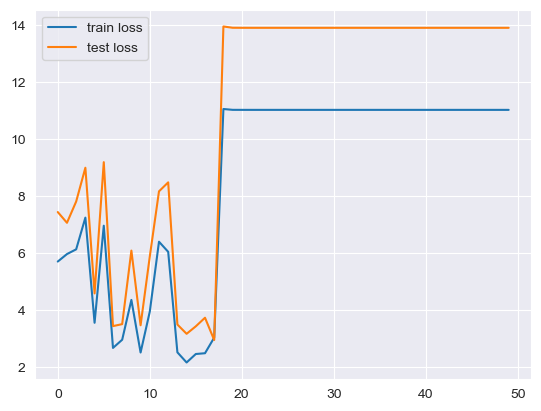

In [38]:
# 实例化模型
relu_lr_l3 = L3ReLULR(bias=False)

# 超参数
num_epochs = 50
lr = 0.03

# 迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs, lr=lr)

# 可视化训练结果
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 模型在迭代很多轮之后，不一定会在最小值处收敛，甚至会在损失的较高位收敛，损失并没有随着迭代次数的增加而减少

In [39]:
# 进一步查看模型对数据的输出
relu_lr_l3(features)[:30]  # 模型对数据的预测结果大都为0

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)

### Dead ReLU Problem原因分析
神经元活性失效问题与ReLU激活函数本身的特点有关。先观察ReLU函数与导函数的曲线。

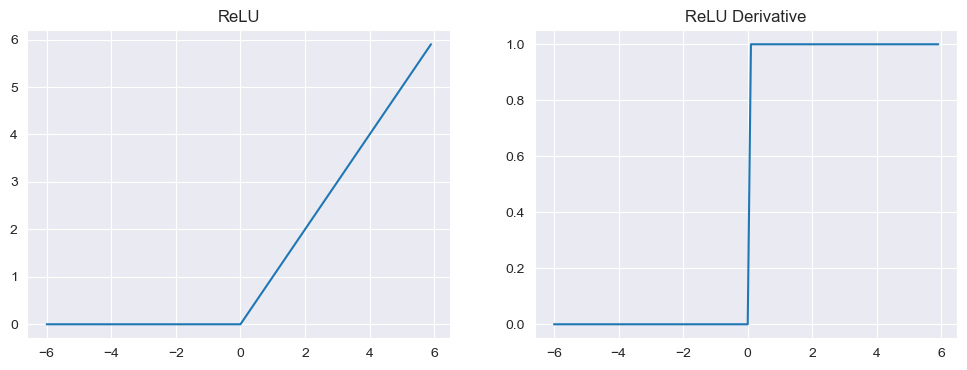

In [40]:
# 绘制ReLU函数及其导函数的图像
X = torch.arange(-6, 6, 0.1, requires_grad=True)
r = torch.relu(X)

# 反向传播，求解梯度
r.sum().backward()

# 可视化ReLU函数与导函数
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(X.detach(), r.detach())
plt.title('ReLU')
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title('ReLU Derivative')
plt.show()

可以看到，对于ReLU激活函数来说，只要激活函数的输入小于0，输出结果就全是0，并且更关键的是，只要ReLU输出结果是0，由于ReLU的导函数是分段常数函数且接收数据为负时导数为0，因此如果ReLU输出结果为零，则反向传播结果、也就是各层的梯度，也都是零。
现在进一步通过举例说明，假设现在有模型：输入层有2个神经元、隐含层有2个神经元（带有ReLU激活函数）、输出层有1个神经元，同时假设第1层和第2层的权重分别为w1和w2，feature为输入的特征张量，且只有1条数据，label为对应的标签。

In [41]:
# 数据
feature = torch.tensor([[1., 2]])
label = torch.tensor([[3.]])

# 权重
w1 = torch.tensor([[0., 0], [-1, -2]], requires_grad=True)
w2 = torch.tensor([[1.], [-1]], requires_grad=True)

# 第1次前向传播
out = feature @ w1
print(out)
out = F.relu(out)
print(out)
out = out @ w2
print(out)

tensor([[-2., -4.]], grad_fn=<MmBackward0>)
tensor([[0., 0.]], grad_fn=<ReluBackward0>)
tensor([[0.]], grad_fn=<MmBackward0>)


In [42]:
# 计算损失
loss = F.mse_loss(out, label)
print(loss)
# 反向传播
loss.backward()
# 查看梯度
w1.grad, w2.grad

tensor(9., grad_fn=<MseLossBackward0>)


(tensor([[0., 0.],
         [0., 0.]]),
 tensor([[0.],
         [0.]]))

可以看到，当某条数据在模型中的输出结果为0时，反向传播后各层参数的梯度也全为0，此时参数将无法进行迭代更新，模型也就失去了学习能力。同时，如果在某种参数情况下，整个训练数据集输入模型之后的输出都是0，则在小批量梯度下降的情况下，每次挑选出一个batch的数据继续进行迭代，无法改变输出结果是0的情况，此时梯度为0、参数无法得到更新，进而下次输入的小批数据结果还是零、从而梯度为0、参数无法更新……至此陷入死循环，模型失效、激活函数失去活性，也就出现了Dead ReLU Problem。以上面的模型为例从数学的角度进行验证：
模型预测值：
$$\hat y = ReLU(X * w_1) * w_2$$
出现Dead ReLU Problem时，某一组$w_1$恰好使得ReLU输出结果为0，可得$\hat y = 0$，损失函数的表达式为：
$$loss = MSE = \frac{\sum ((\hat y - y) ^ 2)}{N} $$
梯度为：
$$
\begin{aligned}
grad &= ( \frac{\partial loss}{\partial w_1}, \frac{\partial loss}{\partial w_2}) \\
&= (\frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_1}, \frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_2})\\
\end{aligned}
$$
由于$\hat y$是一个常量、恒为0，由ReLU激活函数导函数特性可知，$\hat y$对任何自变量的偏导都为0，所以grad也就为0，$w_1$、$w_2$不会再更新。而参数不更新，$\hat y$仍然为0，梯度还是为0，如此往复，就出现了死循环，也就是Dead ReLU Problem。
### Dead ReLU Problem发生概率
Dead ReLU Problem问题的概率会伴随ReLU层的增加而增加。在前面1层ReLU激活函数的基础上再增加一层ReLU，此时前向传播的输出结果为：
$$\hat y = ReLU(ReLU(X * w_1) * w_2) * w_3$$
可以看到，在两层ReLU嵌套的情况下，各个部分满足输入到ReLU的值为负，即ReLU输出和其对应的导函数的值为0的概率越来越大，因此模型的输出为0的概率也随之增大，同时针对于各层的梯度计算的各个因子为0的概率增大，例如对于第1层的权重梯度公式$grad_1 = \frac{\partial loss}{\partial \hat y} \cdot w_3 \cdot f(F(X*w_1)*w_2) \cdot F(X * w_1) $来说，只要有一个因子为0，则整体的梯度值都会为0。同时，在多个ReLU激活函数堆叠的情况下，只要其中任意一层输出结果是0，则所有层参数的梯度均为0。

In [43]:
# 验证ReLU激活函数是否失效，即模型在训练集上的输出是否为0
(relu_lr_l3(features[train_loader.dataset.indices]) == 0).sum()  # 基本上都为0，说明ReLU活性失效的现象很严重

tensor(800)

如果模型是带入偏差进行的建模，出现Dead ReLU Problem时模型的输出结果恒为bias的取值。

在所有的解决Dead ReLU Problem的方法中，最简单的一种方法就是调整学习率。ReLU叠加越多层越容易出现神经元活性失效，可以简单通过降低学习率的方法来缓解神经元活性失效的问题，这也是一种通用且有效的方法。学习率作为模型重要的超参数，会在各方面影响模型效果，学习率越小、收敛速度就越慢，而学习率过大、则又容易跳过最小值点造成模型结果震荡，对于ReLU激活函数来说，参数“稍有不慎”就容易落入输出值全为0的陷阱，因此训练过程需要更加保守谨慎，即采用更小的学习率逐步迭代，同时学习率减少就必然需要增加迭代次数，但由于ReLU激活函数计算过程相对简单，增加迭代次数并不会显著增加计算量。下面通过可视化来查看学习率减小带来的效果。

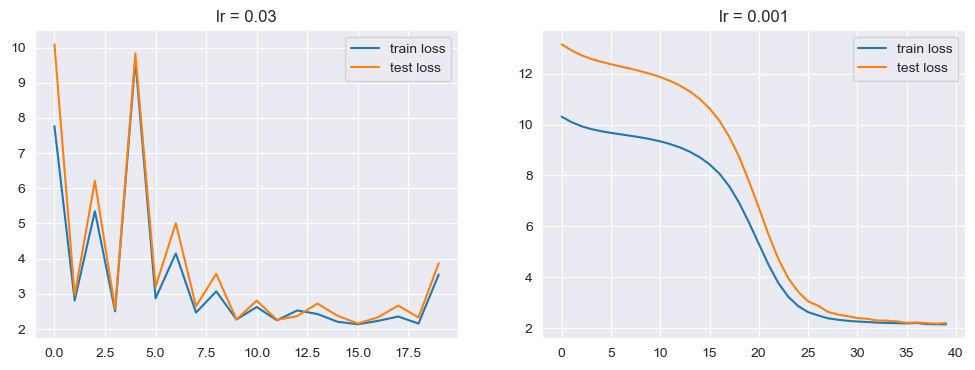

In [44]:
# 实例化模型
relu_lr_l3 = L3ReLULR()  # 带偏差

# 超参数
num_epochs = 20
lr = 0.03  # 原始学习率

# 迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs)

# 可视化训练结果
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.title(f'lr = {lr}')
plt.legend()

# 实例化模型
relu_lr_l3 = L3ReLULR()  # 带偏差

# 超参数
num_epochs = 40  # 增大迭代次数
lr = 0.001  # 减小学习率

# 迭代训练
train_losses, test_losses = train_test_model(relu_lr_l3, train_loader, test_loader, num_epochs=num_epochs, lr=lr)

# 可视化训练结果
plt.subplot(122)
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.title(f'lr = {lr}')
plt.legend()
plt.show()  # 减小学习率后，模型更容易避开神经元活性失效的陷阱，也更平滑

## 6.ReLU激活函数特性
ReLU激活函数的一个明显的作用是**选择性更新部分参数**：当激活函数是ReLU激活函数时，以2层ReLU模型为例，其中第1层的权重梯度公式为$grad_1 = \frac{\partial loss}{\partial \hat y} \cdot w_3 \cdot f(F(X*w_1)*w_2) \cdot F(X * w_1) $，2、3层梯度更是相对更简短，无论是第1层接收到的数值（$X*w_1$）小于0，还是第2层接收到的数值（$F(X*w_1)*w_2$）小于0，都会导致三层参数的梯度为0，同时，哪怕是第1层接收到的数据全是0，也会导致所有参数本轮不被更新。在实际深度学习建模过程中，是采用小批量梯度下降算法来进行梯度计算的，如果某一批的数据输出结果为0，则当前迭代结束时参数不变，也就相当于模型区别性地选择数据进行参数更新，选择了那些输出结果不为0的数据进行参数训练。这一轮某一批数据没被选择，不代表下一轮这批数据仍然不被选择（因为参数会变化，因而输出结果也会发生变化），因此可以理解为每一轮都随机地带入不同数据进行参数训练，从而最终完成模型训练。每次带入不同批次数据训练，或者说每次有选择地忽略部分数据，就是一种非线性转换的体现。也正因如此，ReLU激活函数也被称为非饱和激活函数。
同时，从梯度消失和梯度爆炸的角度考虑，ReLU激活函数拥有更加优异的特性。因为ReLU激活函数的导函数取值要么是1、要么是0，因此当导函数取值为1时，能够保证各层参数的梯度在计算时不受因层数变化而累乘的导函数影响。也就是说，在不存在Dead ReLU Problem的时候，**ReLU激活函数可以保证深度模型前几层的梯度更加平稳**。

随机性的用武之处有很多：
- 集成模型将在一定随机性条件下构建的、彼此不同的基分类器进行集成，从而创建一个效果明显好于单个基分类器的集成模型
- SGD采用每次带入随机部分数据的方法进行梯度下降迭代，从而使得迭代过程能够跳出局部最小值点
- ReLU激活函数随机挑选部分参数进行迭代，从而完成数据的“非线性”转化，以保证模型本身的有效性

In [45]:
# 观察模型训练结束后各层参数的梯度
for module in relu_lr_l3.modules():
    if isinstance(module, nn.Linear):
        print(module.weight.grad)

tensor([[-1.2407,  1.7413],
        [ 0.7048, -4.1306],
        [-1.6843,  2.5145],
        [ 0.3542, -0.5832]])
tensor([[ 1.3504e-02,  1.0266e-03,  1.1422e-02,  5.6543e-03],
        [-8.8360e-01, -3.1917e-01, -5.7980e-01, -1.1921e+00],
        [ 4.2820e-01,  2.4184e-01,  3.1365e-01,  4.7224e-01],
        [ 1.3154e+00,  4.0672e-01,  8.4900e-01,  1.7975e+00]])
tensor([[-0.0459,  0.0129, -0.0359, -0.0766],
        [ 0.2487,  0.1200,  0.3034,  0.4639],
        [ 0.1142,  1.2203,  0.9871,  0.8132],
        [-0.0729, -0.7459, -0.6675, -0.5625]])
tensor([[-0.0102,  0.3671,  0.7360,  0.8735]])


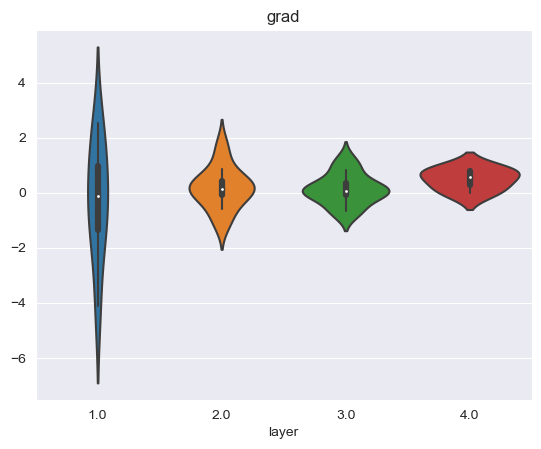

In [46]:
# 可视化各层梯度
violin_plot_layers(relu_lr_l3)

可以看到，模型各层仍然处在学习状态，虽然存在梯度不均和梯度爆炸的情况，但在学习率非常小的情况下参数的更新幅度会很小、整体表现仍然较为平稳。同时需要注意，对于ReLU激活函数来说，每一层梯度分布的小提琴图会很大程度受到梯度0值的影响，并且每一次迭代完成后是否取0值都会发生变化，从而影响小提琴图对真实情况反应的准确程度。
## 7.nn.Sequential快速建模方法和nn.init模型参数自定义方法
### nn.Sequential快速建模
前面搭建模型，都是通过完整的创建模型类、通过定义init方法和forward方法来确定模型的基本结构、传播方式和激活函数，除了这种模型定义方法外，PyTorch还支持使用nn.Sequential来快速构建子模块具有前后顺序关系的模型，在借助nn.Sequential构建模型时，只需要将每一层神经元连接方法和激活函数作为参数输入nn.Sequential即可。

In [47]:
# 快速构建模型：构建的是已经实例化的模型
relu_lr_l1 = nn.Sequential(nn.Linear(2, 2, bias=False), nn.ReLU(),
                           nn.Linear(2, 1, bias=False))  # 相当于是两层全连接神经网络，并且隐藏层使用ReLU进行处理
list(relu_lr_l1.parameters())  # 查看参数

[Parameter containing:
 tensor([[ 0.1224,  0.0579],
         [-0.2417, -0.0370]], requires_grad=True),
 Parameter containing:
 tensor([[0.0771, 0.4187]], requires_grad=True)]

In [48]:
isinstance(relu_lr_l1, nn.Sequential)  # 通过nn.Sequential创建的模型本质上都是nn.Sequential的实例

True

In [49]:
# nn.ReLU()单独使用时就相当于ReLU函数，作为模型的一个子层就等价于对某一层的输出结果进行ReLU处理
feature = torch.randint(-3, 3, size=(1, 6))
feature, nn.ReLU()(feature), F.relu(feature)

(tensor([[ 2,  2, -1, -3,  1, -1]]),
 tensor([[2, 2, 0, 0, 1, 0]]),
 tensor([[2, 2, 0, 0, 1, 0]]))

In [50]:
# 模型进行前向传播
feature = torch.randn(4, 2)
relu_lr_l1(feature)

tensor([[0.0121],
        [0.0222],
        [0.1065],
        [0.0094]], grad_fn=<MmBackward0>)

In [51]:
# 手动验证
modules = list(relu_lr_l1.modules())[1:]
F.relu(feature @ modules[0].weight.t()) @ modules[2].weight.t()  # 与前面结果一致

tensor([[0.0121],
        [0.0222],
        [0.1065],
        [0.0094]], grad_fn=<MmBackward0>)

可以看到，利用nn.Sequential进行模型创建在模型结构相对简单时可以大幅减少代码量，并且模型效果和先通过定义类、再进行实例化的模型效果相同，但该方法不太适合定义高度复杂的模型和定义更加灵活的模型。
### nn.init模型参数自定义
模型可以调用parameters()方法获取模型的所有参数，返回结果是一个生成器。

In [52]:
# 获取模型参数
relu_lr_l1.parameters(), list(relu_lr_l1.parameters())

(<generator object Module.parameters at 0x00000224DAE4EBA0>,
 [Parameter containing:
  tensor([[ 0.1224,  0.0579],
          [-0.2417, -0.0370]], requires_grad=True),
  Parameter containing:
  tensor([[0.0771, 0.4187]], requires_grad=True)])

In [53]:
# 1.通过修改张量手动修改参数
w1 = torch.tensor([[0., 0], [-1, -2]])
w2 = torch.tensor([[1.], [-1]])
list(relu_lr_l1.parameters())[0].data = w1.t()
list(relu_lr_l1.parameters())[1].data = w2.t()

list(relu_lr_l1.parameters())  # 修改成功

[Parameter containing:
 tensor([[ 0., -1.],
         [ 0., -2.]], requires_grad=True),
 Parameter containing:
 tensor([[ 1., -1.]], requires_grad=True)]

In [54]:
# 测试前向传播
relu_lr_l1(feature)  # 正常执行

tensor([[ 0.0000],
        [-0.7992],
        [-2.1312],
        [-0.3945]], grad_fn=<MmBackward0>)

In [55]:
# 2.使用init模块创建满足某种分布的参数
relu_lr_l1 = nn.Sequential(nn.Linear(2, 2, bias=False), nn.ReLU(), nn.Linear(2, 1, bias=False))
list(relu_lr_l1.parameters())  # 查看参数

[Parameter containing:
 tensor([[0.3869, 0.2452],
         [0.5967, 0.2651]], requires_grad=True),
 Parameter containing:
 tensor([[-0.3689, -0.0943]], requires_grad=True)]

In [56]:
# （1）nn.init.uniform_：新生成的参数服从均匀分布
nn.init.uniform_(list(relu_lr_l1.parameters())[0], 1, 2)  # 1到2之间的均匀分布
list(relu_lr_l1.parameters())  # 查看参数，发生改变

[Parameter containing:
 tensor([[1.0887, 1.7552],
         [1.6228, 1.4071]], requires_grad=True),
 Parameter containing:
 tensor([[-0.3689, -0.0943]], requires_grad=True)]

In [57]:
# （2）nn.init.normal_：新生成的参数服从正态分布
nn.init.normal_(list(relu_lr_l1.parameters())[0], 5, 2)  # 均值为5、标准差为2的正态分布
list(relu_lr_l1.parameters())  # 查看参数，发生改变

[Parameter containing:
 tensor([[6.0779, 8.3384],
         [6.5363, 7.1137]], requires_grad=True),
 Parameter containing:
 tensor([[-0.3689, -0.0943]], requires_grad=True)]

In [58]:
# （3）nn.init.constant_：新生成的参数为某一常数
nn.init.constant_(list(relu_lr_l1.parameters())[0], 10)  # weight参数值全为10
list(relu_lr_l1.parameters())  # 查看参数，发生改变

[Parameter containing:
 tensor([[10., 10.],
         [10., 10.]], requires_grad=True),
 Parameter containing:
 tensor([[-0.3689, -0.0943]], requires_grad=True)]

上面的3种权重初始化的方式并不复杂，并且实现相同的修改目标也有对应的手动方式可以实现。对于nn.init模块来说，最核心的使用场景是能够创建服从特殊分布、具备一定特性的、能够辅助模型迭代收敛的初始参数。